Dataloader:

In [1]:
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader
import torch

# --- DEFINE HYPERPARAMETERS ---
T_steps = 1000  # Total number of diffusion steps
IMG_SIZE = 32 # CIFAR-10 image size
BATCH_SIZE = 64
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Define the transform. We use the same for train and val.
# We normalize to [-1, 1], which is standard for diffusion models
transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor()
    # T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Scale to [-1, 1]
])

# --- Train Dataloader ---
train_dataset = torchvision.datasets.CIFAR10(
    root="data",
    train=True,
    download=True, # Will use local data if already downloaded
    transform=transform
)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

# --- Validation/Test Dataloader ---
# We use the CIFAR-10 "test" set as our validation set.
val_dataset = torchvision.datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transform
)
# No shuffle for val/test loader, use more workers if available
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Data loaded: {len(train_dataset)} train images, {len(val_dataset)} validation images.")
print("Created 'train_loader' and 'val_loader'.")

Data loaded: 50000 train images, 10000 validation images.
Created 'train_loader' and 'val_loader'.


Forward diffusion process:

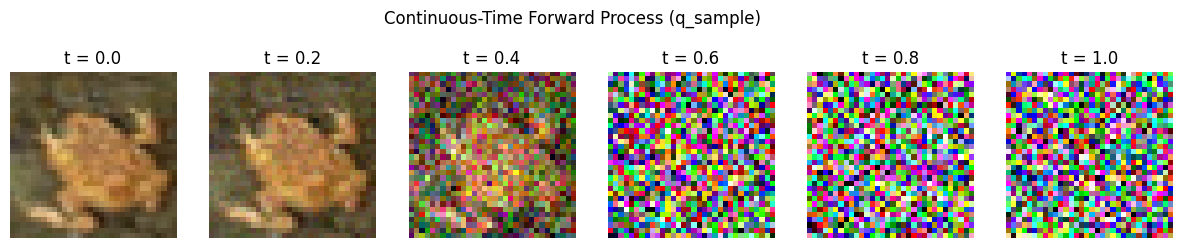

In [13]:
import torch
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# --- 1. DEFINE HYPERPARAMETERS ---
# T_steps is no longer needed for training, but we'll need it for sampling later
# Let's keep it defined here for now.
T_STEPS_FOR_SAMPLING = 1000 
IMG_SIZE = 32
BATCH_SIZE = 64
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --- 2. DEFINE THE CONTINUOUS-TIME SCHEDULE (Functions) ---
# We define gamma as a function of t (float in [0, 1])

GAMMA_MIN = -10.0
GAMMA_MAX = 10.0

def gamma(t):
    """Returns gamma(t) for any t in [0, 1] (linear schedule)"""
    return (GAMMA_MAX - GAMMA_MIN) * t + GAMMA_MIN

def alpha_t_sq(t):
    """Returns $\alpha_t^2 = \text{sigmoid}(-\gamma(t))$"""
    return torch.sigmoid(-gamma(t))

def sigma_t_sq(t):
    """Returns $\sigma_t^2 = \text{sigmoid}(\gamma(t))$"""
    return torch.sigmoid(gamma(t))

def sqrt_alpha_t_sq(t):
    """Returns $\alpha_t = \sqrt{\text{sigmoid}(-\gamma(t))}$"""
    return torch.sqrt(alpha_t_sq(t))

def sqrt_sigma_t_sq(t):
    """Returns $\sigma_t = \sqrt{\text{sigmoid}(\gamma(t))}$"""
    return torch.sqrt(sigma_t_sq(t))

# --- 4. THE FORWARD (NOISING) FUNCTION ---
# This function is now updated to use the schedule functions

def q_sample(x_start, t, noise=None):
    """
    Noises a batch of images x_start to a specific continuous time t.
    x_start: (B, C, H, W) - the original clean images
    t: (B,) - a tensor of FLOATS from [0, 1]
    """
    if noise is None:
        noise = torch.randn_like(x_start, device=DEVICE)

    # 1. Get $\alpha_t$ and $\sigma_t$ by calling the functions
    # We must reshape t to (B, 1, 1, 1) to make the functions output
    # the correct broadcastable shape.
    t_broadcast = t.reshape(-1, 1, 1, 1)
    
    sqrt_alpha_t_sq_t = sqrt_alpha_t_sq(t_broadcast)
    sqrt_sigma_t_sq_t = sqrt_sigma_t_sq(t_broadcast)

    # 3. Apply the formula
    # x_t = \alpha_t * x_0 + \sigma_t * noise
    noisy_image = sqrt_alpha_t_sq_t * x_start + sqrt_sigma_t_sq_t * noise
    
    return noisy_image, noise

# --- 5. HELPER FUNCTION FOR VISUALIZATION ---
def unnormalize_img(img_tensor):
    """Converts a tensor from [-1, 1] to [0, 1] for plotting."""
    img_tensor = (img_tensor + 1) * 0.5
    img_tensor = torch.clamp(img_tensor, 0, 1) # Clamp values
    img_tensor = img_tensor.permute(1, 2, 0) # (C, H, W) -> (H, W, C)
    return img_tensor.cpu().numpy()

# --- 6. DATA LOADING & VISUALIZATION TEST ---
if __name__ == "__main__":
    # Load CIFAR-10
    transform = T.Compose([
        T.Resize((IMG_SIZE, IMG_SIZE)),
        T.ToTensor(),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Scale to [-1, 1]
    ])
    
    # (Using train_loader and val_loader from your other cell is better,
    # but this test still works to visualize the continuous sampling)
    dataset = torchvision.datasets.CIFAR10(
        root="data", 
        train=True, 
        download=False, 
        transform=transform
    )
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    x_start_batch, _ = next(iter(dataloader))
    x_start_batch = x_start_batch.to(DEVICE)
    x_start_single = x_start_batch[0].unsqueeze(0)

    # Define a few timesteps to visualize
    timesteps_to_show = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0] # FLOATS now
    num_steps = len(timesteps_to_show)
    
    fig, axes = plt.subplots(1, num_steps, figsize=(15, 3))
    fig.suptitle("Continuous-Time Forward Process (q_sample)")

    for i, t_val in enumerate(timesteps_to_show):
        # Create a tensor for the timestep
        t = torch.tensor([t_val], device=DEVICE).float() # .float()
        
        noisy_img, _ = q_sample(x_start_single, t)
        
        axes[i].imshow(unnormalize_img(noisy_img[0]))
        axes[i].set_title(f"t = {t_val:.1f}")
        axes[i].axis('off')

    plt.show()

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# --- Sinusoidal Time Embedding ---
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        """
        Input:
            time: (B,) tensor of time steps
        Output:
            (B, dim) tensor of embeddings
        """
        device = time.device
        half_dim = self.dim // 2

        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)

        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)

        return embeddings

# --- Core Building Block ---
class SimpleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim):
        super().__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.norm = nn.GroupNorm(8, out_channels)
        self.act = nn.SiLU()

        self.time_mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, out_channels)
        )

    def forward(self, x, t_emb):
        h = self.conv(x)
        h = self.norm(h)

        time_bias = self.time_mlp(t_emb)
        h = h + time_bias.unsqueeze(-1).unsqueeze(-1)

        return self.act(h)

# --- The U-Net Architecture ---
# This version is closer to the VDM paper's CIFAR-10 model.
# All operations happen at the same 32x32 resolution.

class SimpleUNet(nn.Module):
    def __init__(self, img_channels=3, base_dim=64, time_emb_dim=256):
        """
        A U-Net without downsampling/upsampling.
        Resolution stays constant (e.g., 32x32).
        """
        super().__init__()

        # --- Time Embedding ---
        self.time_mlp = SinusoidalPositionEmbeddings(time_emb_dim)

        # --- Input ---
        # Input: (B, 3, 32, 32)
        self.conv_in = SimpleBlock(img_channels, base_dim, time_emb_dim) # (B, 64, 32, 32)

        # --- Encoder Path (No Pooling) ---
        self.down1 = SimpleBlock(base_dim, base_dim*2, time_emb_dim)     # 64 -> 128
        self.down2 = SimpleBlock(base_dim*2, base_dim*4, time_emb_dim)   # 128 -> 256

        # --- Bottleneck ---
        self.mid1 = SimpleBlock(base_dim*4, base_dim*8, time_emb_dim)     # 256 -> 512
        self.mid2 = SimpleBlock(base_dim*8, base_dim*4, time_emb_dim)     # 512 -> 256

        # --- Decoder Path (No Upsampling) ---
        # Skip connection 1
        # Input: mid2 (256) + down2 (256) = 512
        self.up1_block = SimpleBlock(base_dim*4 + base_dim*4, base_dim*2, time_emb_dim) # 512 -> 128

        # Skip connection 2
        # Input: up1 (128) + down1 (128) = 256
        self.up2_block = SimpleBlock(base_dim*2 + base_dim*2, base_dim, time_emb_dim) # 256 -> 64

        # --- Output ---
        # Skip connection 3
        # Input: up2 (64) + conv_in (64) = 128
        self.conv_out_block = SimpleBlock(base_dim + base_dim, base_dim, time_emb_dim) # 128 -> 64
        self.conv_out = nn.Conv2d(base_dim, img_channels, kernel_size=1) # 64 -> 3

    def forward(self, x_t, time):
        """
        Input:
            x_t: (B, C, H, W) noisy image at step t
            time: (B,) time steps
        Output:
            (B, C, H, W) predicted noise
        """

        # 1. Get time embedding
        t_emb = self.time_mlp(time)

        # 2. Encoder
        h_in = self.conv_in(x_t, t_emb)  # (B, 64, 32, 32)
        h_d1 = self.down1(h_in, t_emb)   # (B, 128, 32, 32)
        h_d2 = self.down2(h_d1, t_emb)   # (B, 256, 32, 32)

        # 3. Bottleneck
        h_mid = self.mid1(h_d2, t_emb)   # (B, 512, 32, 32)
        h_mid = self.mid2(h_mid, t_emb)  # (B, 256, 32, 32)

        # 4. Decoder
        # Skip connection 1
        up1_in = torch.cat([h_mid, h_d2], dim=1) # (B, 256 + 256 = 512, 32, 32)
        h_up1 = self.up1_block(up1_in, t_emb)    # (B, 128, 32, 32)

        # Skip connection 2
        up2_in = torch.cat([h_up1, h_d1], dim=1) # (B, 128 + 128 = 256, 32, 32)
        h_up2 = self.up2_block(up2_in, t_emb)    # (B, 64, 32, 32)

        # Skip connection 3
        out_in = torch.cat([h_up2, h_in], dim=1) # (B, 64 + 64 = 128, 32, 32)
        h_out = self.conv_out_block(out_in, t_emb) # (B, 64, 32, 32)

        # 5. Output
        return self.conv_out(h_out) # (B, 3, 32, 32)

# --- 4. TEST THE MODEL ---
if __name__ == "__main__":
    # Define some dummy values
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    T_steps = 1000 # Total timesteps

    # 1. Create dummy noisy image batch
    dummy_x = torch.randn(8, 3, 32, 32, device=DEVICE)

    # 2. Create dummy time batch
    dummy_t = torch.randint(0, T_steps, (8,), device=DEVICE).long()

    # 3. Initialize model and move to device
    # *** USE THE NEW MODEL NAME ***
    model = SimpleUNet().to(DEVICE)
    print(model)

    # 4. Run forward pass
    predicted_noise = model(dummy_x, dummy_t)

    # 5. Check output shape
    print("--- U-Net Test ---")
    print(f"Input image shape: {dummy_x.shape}")
    print(f"Input time shape:  {dummy_t.shape}")
    print(f"Output noise shape: {predicted_noise.shape}")

    assert dummy_x.shape == predicted_noise.shape
    print("\nSuccess! Output shape matches input shape.")

SimpleUNet(
  (time_mlp): SinusoidalPositionEmbeddings()
  (conv_in): SimpleBlock(
    (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
    (act): SiLU()
    (time_mlp): Sequential(
      (0): SiLU()
      (1): Linear(in_features=256, out_features=64, bias=True)
    )
  )
  (down1): SimpleBlock(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm): GroupNorm(8, 128, eps=1e-05, affine=True)
    (act): SiLU()
    (time_mlp): Sequential(
      (0): SiLU()
      (1): Linear(in_features=256, out_features=128, bias=True)
    )
  )
  (down2): SimpleBlock(
    (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm): GroupNorm(8, 256, eps=1e-05, affine=True)
    (act): SiLU()
    (time_mlp): Sequential(
      (0): SiLU()
      (1): Linear(in_features=256, out_features=256, bias=True)
    )
  )
  (mid1): SimpleBlock(
    (conv): Conv2d(256, 512, kernel_

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# (This cell assumes T, IMG_SIZE are defined in your vdm forward pass cell)
# (This cell assumes UNet is defined in your vdm_unet cell)

# --- 1. Hyperparameters ---
LEARNING_RATE = 1e-4  
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --- 2. Initialize Model ---
# Move the model to the correct device (GPU or CPU)
model = SimpleUNet().to(DEVICE)

# --- 3. Define Loss Function ---
# We are predicting noise, so we use MSE Loss (L2 Loss).
# This measures the distance between the true noise (epsilon)
# and the noise predicted by the U-Net (model_output).
loss_fn = nn.MSELoss()

# --- 4. Define Optimizer ---
# Adam is a robust optimizer that works well for this task.
# We pass it the model's parameters (which it will update)
# and the learning rate.
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# --- 5. Confirmation & Test ---
print("--- Setup Complete ---")
print(f"Using device: {DEVICE}")
print(f"Model: {model.__class__.__name__}")
print(f"Loss Fn: {loss_fn.__class__.__name__}")
print(f"Optimizer: {optimizer.__class__.__name__}")

# Quick test to ensure everything is connected:
try:
    dummy_x = torch.randn(2, 3, IMG_SIZE, IMG_SIZE, device=DEVICE)
    dummy_t = torch.randint(0, T_steps, (2,), device=DEVICE).long()

    # 1. Forward pass
    pred_noise = model(dummy_x, dummy_t)

    # 2. Calculate loss
    true_noise = torch.randn_like(pred_noise)
    loss = loss_fn(pred_noise, true_noise)

    # 3. Backward pass and optimizer step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print("\nTest step successful! (Forward, backward, and optimizer step ran.)")

except NameError as e:
    print(f"\n---")
    print(f"Test step failed: {e}")
except Exception as e:
    print(f"\nTest step failed with an unexpected error: {e}")


--- Setup Complete ---
Using device: cuda
Model: SimpleUNet
Loss Fn: MSELoss
Optimizer: Adam

Test step successful! (Forward, backward, and optimizer step ran.)


--- Starting Training with Dequantization ---

--- Epoch 1/20 ---

--- Running Validation at Step 500 ---
Step 500      Training Loss: 0.1449  |  Validation Loss: 0.1454
Epoch 1 Complete. Time taken: 53.11s

--- Epoch 2/20 ---

--- Running Validation at Step 1000 ---
Step 1000     Training Loss: 0.1415  |  Validation Loss: 0.1449

--- Running Validation at Step 1500 ---
Step 1500     Training Loss: 0.1459  |  Validation Loss: 0.1426
Epoch 2 Complete. Time taken: 56.68s

--- Epoch 3/20 ---

--- Running Validation at Step 2000 ---
Step 2000     Training Loss: 0.1437  |  Validation Loss: 0.1439
Epoch 3 Complete. Time taken: 52.87s

--- Epoch 4/20 ---

--- Running Validation at Step 2500 ---
Step 2500     Training Loss: 0.1473  |  Validation Loss: 0.1440

--- Running Validation at Step 3000 ---
Step 3000     Training Loss: 0.1440  |  Validation Loss: 0.1450
Epoch 4 Complete. Time taken: 56.60s

--- Epoch 5/20 ---

--- Running Validation at Step 3500 ---
Step 3500     Training Loss: 0.1428 

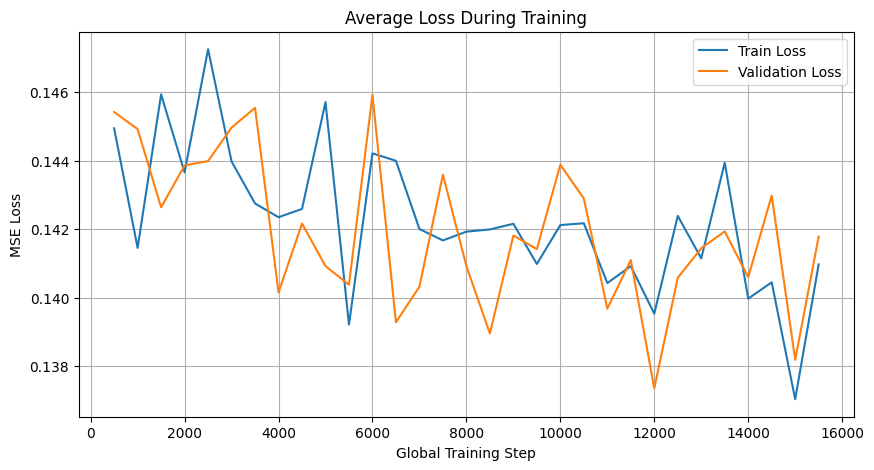

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import time 

# (This cell assumes all variables from previous cells are defined and in scope)
# Requires:
#   - train_loader, val_loader
#   - T_STEPS_FOR_SAMPLING (e.g., 1000)
#   - q_sample (the NEW continuous function)
#   - model (your UNet_NoPool)
#   - loss_fn, optimizer, DEVICE
#   - T_STEPS_FOR_SAMPLING

# --- 1. Training Hyperparameters ---
EPOCHS = 20 
VALIDATION_EVERY_STEPS = 500
global_step = 0

train_loss_history = []
val_loss_history = []
step_history = []

# --- 2. Dequantization Constants ---
# We use 256 for 8-bit images (0-255)
VOCAB_SIZE = 256

# --- 3. The Training Loop ---
print("--- Starting Training with Dequantization ---")
model.train() 

for epoch in range(EPOCHS):
    print(f"\n--- Epoch {epoch+1}/{EPOCHS} ---")
    
    batch_train_losses = []
    epoch_start_time = time.time()

    for step, (images, _) in enumerate(train_loader):
        # --- TRAINING STEP ---

        # 1. Prepare Data (with Dequantization)
        x_start_0_to_1 = images.to(DEVICE) # (B, C, H, W), range [0, 1]
        batch_size = x_start_0_to_1.shape[0]

        # (a) Convert 0-1 float to 0-255 int
        img_int = torch.round(x_start_0_to_1 * (VOCAB_SIZE - 1)).long()
        
        # (b) Dequantize: (int + rand) / 256.0
        # This adds uniform noise to convert discrete pixels to continuous data
        x_dequant = (img_int.float() + torch.rand_like(x_start_0_to_1)) / VOCAB_SIZE
        
        # (c) Rescale to [-1, 1] for the U-Net
        x_start = 2.0 * x_dequant - 1.0
        
        # 2. Create Training Data
        t = torch.rand(batch_size, device=DEVICE) # Sample t from [0, 1]
        x_t_noisy, true_noise = q_sample(x_start, t)
        
        # 3. Run Model
        predicted_noise = model(x_t_noisy, t)
        
        # --- THIS IS OUR NEXT STEP ---
        # For now, we still use the simple MSE loss.
        # We will replace this with the full VLB loss soon.
        loss = loss_fn(predicted_noise, true_noise)
        # -----------------------------
        
        # 4. Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 5. Logging
        batch_train_losses.append(loss.item())
        global_step += 1

        # --- VALIDATION STEP ---
        if global_step % VALIDATION_EVERY_STEPS == 0:
            print(f"\n--- Running Validation at Step {global_step} ---")
            
            avg_train_loss = np.mean(batch_train_losses)
            train_loss_history.append(avg_train_loss)
            batch_train_losses = [] 
            
            model.eval()
            total_val_loss = 0.0
            
            with torch.no_grad():
                for val_images, _ in val_loader:
                    # 1. Prepare Data (with Dequantization)
                    x_start_0_to_1_val = val_images.to(DEVICE)
                    batch_size_val = x_start_0_to_1_val.shape[0]
                    img_int_val = torch.round(x_start_0_to_1_val * (VOCAB_SIZE - 1)).long()
                    x_dequant_val = (img_int_val.float() + torch.rand_like(x_start_0_to_1_val)) / VOCAB_SIZE
                    x_start_val = 2.0 * x_dequant_val - 1.0

                    # 2. Create Validation Data
                    t_val = torch.rand(batch_size_val, device=DEVICE)
                    x_t_noisy_val, true_noise_val = q_sample(x_start_val, t_val)
                    
                    # 3. Run Model
                    predicted_noise_val = model(x_t_noisy_val, t_val)
                    val_loss = loss_fn(predicted_noise_val, true_noise_val)
                    total_val_loss += val_loss.item()
            
            avg_val_loss = total_val_loss / len(val_loader)
            val_loss_history.append(avg_val_loss)
            step_history.append(global_step)

            print(f"Step {global_step:<7}  Training Loss: {avg_train_loss:.4f}  |  Validation Loss: {avg_val_loss:.4f}")
            model.train()
    
    epoch_time = time.time() - epoch_start_time
    print(f"Epoch {epoch+1} Complete. Time taken: {epoch_time:.2f}s")

print("\n--- Training Finished ---")

# --- 4. PLOT THE LOSS CURVES ---
print("Generating loss plot...")
plt.figure(figsize=(10, 5))
plt.plot(step_history, train_loss_history, label="Train Loss")
plt.plot(step_history, val_loss_history, label="Validation Loss")
plt.title("Average Loss During Training")
plt.xlabel("Global Training Step")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()

--- Starting Continuous-Time Sampling (FIXED) ---
Sampling step 0/1000 (t=1.00)
Sampling step 100/1000 (t=0.90)
Sampling step 200/1000 (t=0.80)
Sampling step 300/1000 (t=0.70)
Sampling step 400/1000 (t=0.60)
Sampling step 500/1000 (t=0.50)
Sampling step 600/1000 (t=0.40)
Sampling step 700/1000 (t=0.30)
Sampling step 800/1000 (t=0.20)
Sampling step 900/1000 (t=0.10)
--- Sampling Complete --- (Took 6.59s)
Generating plot of sampled images...


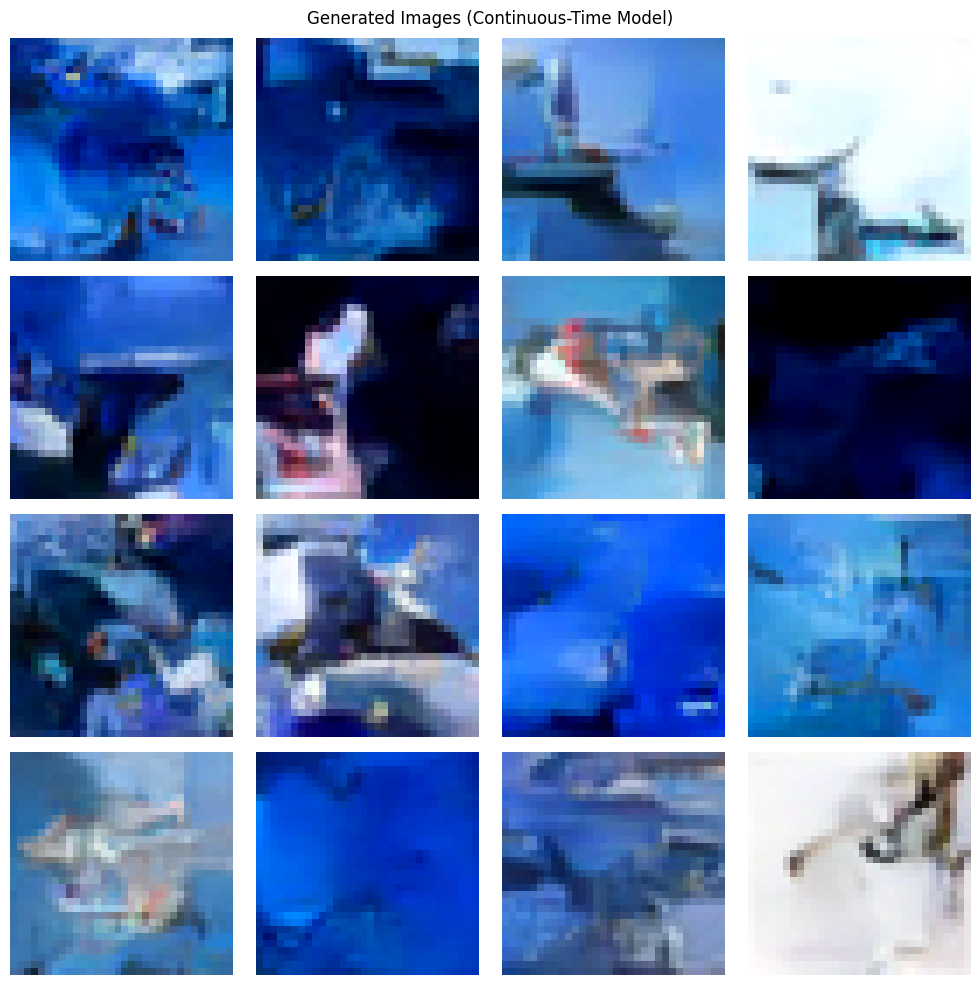

In [17]:
import torch
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F

# (This cell assumes all variables from previous cells are defined and in scope)
# Requires:
#   - model: Trained UNet_NoPool model
#   - T_STEPS_FOR_SAMPLING: (e.g., 1000)
#   - DEVICE: Your "cuda" or "cpu" device
#   - All continuous schedule functions: 
#     gamma(t), sqrt_alpha_t_sq(t), sqrt_sigma_t_sq(t)

# --- Helper function for plotting ---
def unnormalize_img(img_tensor):
    """Converts a tensor from [-1, 1] to [0, 1] for plotting."""
    img_tensor = (img_tensor + 1) * 0.5
    img_tensor = torch.clamp(img_tensor, 0, 1)
    img_tensor = img_tensor.permute(1, 2, 0) # (C, H, W) -> (H, W, C)
    return img_tensor.cpu().numpy()

# --- Single-Step Denoising Function (p_sample) ---

@torch.no_grad()
def p_sample_continuous(model, x_t, t_continuous, t_prev_continuous):
    """
    Performs a single denoising step from continuous time t to s (t_prev)
    """
    batch_size = x_t.shape[0]
    
    # 1. Get schedule values for t and s (t_prev)
    t = t_continuous.reshape(-1, 1, 1, 1)
    s = t_prev_continuous.reshape(-1, 1, 1, 1)

    gamma_t = gamma(t)
    gamma_s = gamma(s)
    
    alpha_t = sqrt_alpha_t_sq(t)
    alpha_s = sqrt_alpha_t_sq(s)
    sigma_t = sqrt_sigma_t_sq(t)
    sigma_s_sq = sigma_t_sq(s) # $\sigma_s^2$
    
    # 2. Predict noise
    predicted_noise = model(x_t, t_continuous) # $\epsilon_\theta(x_t, t)$

    # 3. Calculate mean of x_{s} (x_{t-1})
    # This is Eq. 32 from the VDM paper appendix
    
    c = torch.expm1(gamma_s - gamma_t)
    
    # --- THIS IS THE FIX ---
    # The sign was changed from - to + to match Eq. 32
    model_mean = (alpha_s / alpha_t) * (x_t + sigma_t * c * predicted_noise)
    # -----------------------

    # 4. Calculate variance of x_{s}
    # This is Eq. 33 from the VDM paper appendix
    posterior_variance = sigma_s_sq * (-c)
    
    if t_prev_continuous[0] == 0.0: # If it's the last step
        return model_mean
    else:
        # Add noise
        noise = torch.randn_like(x_t)
        return model_mean + torch.sqrt(posterior_variance) * noise

# --- 3. The Full Sampling Loop ---

@torch.no_grad()
def sample(model, batch_size, channels=3, img_size=IMG_SIZE):
    """
    Generates a batch of new images by sampling from T to 0.
    """
    print("--- Starting Continuous-Time Sampling (FIXED) ---")
    start_time = time.time()

    # 1. Start with pure noise (x_1)
    x_t = torch.randn(
        (batch_size, channels, img_size, img_size),
        device=DEVICE
    )
    # Set t=1.0 for the starting noise
    t_start_continuous = torch.full((batch_size,), 1.0, device=DEVICE, dtype=torch.float)
    # We can just use the random noise directly as x_1
    # x_t = q_sample(torch.zeros_like(x_t), t_start_continuous, noise=x_t)[0]

    # 2. Create the discrete time steps for solving
    steps = torch.linspace(1.0, 0.0, T_STEPS_FOR_SAMPLING + 1, device=DEVICE)

    for i in range(T_STEPS_FOR_SAMPLING):
        t_continuous = steps[i].repeat(batch_size)
        s_continuous = steps[i+1].repeat(batch_size)
        
        if (i) % 100 == 0:
            print(f"Sampling step {i}/{T_STEPS_FOR_SAMPLING} (t={t_continuous[0]:.2f})")
            
        x_t = p_sample_continuous(model, x_t, t_continuous, s_continuous)

    end_time = time.time()
    print(f"--- Sampling Complete --- (Took {end_time - start_time:.2f}s)")
    return x_t

# --- 4. Run Generation and Plot ---
if __name__ == "__main__":

    model.eval()
    NUM_IMAGES = 16
    generated_images = sample(model, batch_size=NUM_IMAGES)

    print("Generating plot of sampled images...")
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    fig.suptitle("Generated Images (Continuous-Time Model)")

    for i, img_tensor in enumerate(generated_images):
        row = i // 4
        col = i % 4
        img_np = unnormalize_img(img_tensor)
        axes[row, col].imshow(img_np)
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()